# Causality: Forecasting Time-series

In this section, we will look at return forecasting for equities using autoregressive models, and we will take a look at old style causality; Granger causality. We will start by spending some time transforming the data to ensure that it is stationary. Granger causality is an old Econometric, and a weak form of causality. We will take a look at this concept, and examine our data-set using it. Of course, every machine learning approach hopes to capture causality, whether its explicitly billed as causal or not. We will look later in this series of notebooks how the ML toolkit equips us to model causality by avoiding overfit and finding better generalisations.

In [7]:
# package for working with tabular data...
import pandas as pd

# package for linear algebra...
import numpy as np

# package for visualising data...
import matplotlib.pyplot as plt
import seaborn as sns

# package for navigating the operating system...
import os

# function to test the stationarity of the time series...
from statsmodels.tsa.stattools import adfuller

As mentioned, we are going to forecast the average returns across all the companies in our dataset. Let us take a look specifically at ```TotalReturnCCY.csv``` to see exactly what we are doing.

In [8]:
df = pd.read_csv("Data/TotalReturn_BaseCCY.csv")
df.head()

,NAME,TICKER,SECTOR,COUNTRY,2020-09-20,2020-08-31,2020-07-31,2020-06-30,2020-05-31,2020-04-30,...,2000-10-31,2000-09-30,2000-08-31,2000-07-31,2000-06-30,2000-05-31,2000-04-30,2000-03-31,2000-02-29,2000-01-31
0,Aberdeen Asset Management PLC,1,Financials,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,...,0.045730,-0.120105,0.207501,-0.016259,0.201910,-0.061498,-0.226854,0.248221,0.435955,0.224755
1,Abbey National Plc,2,Financials,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,...,0.038953,0.095348,0.104281,-0.062044,-0.100452,0.161520,-0.130285,0.221048,-0.072973,-0.241147
2,Chubb Plc,3,Industrials,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001878,-0.129013,0.024722,-0.062093,0.026172,0.031064,0.119904,0.222242,0.026770,-0.111193
3,Kidde Plc,4,Consumer Discretionary,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Amec Foster Wheeler plc,5,Industrials,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.000716,0.034200,0.223598,0.179246,-0.150297,0.251863,-0.096557,0.234714,-0.331340,-0.077761


So, ```TotalReturn_BaseCCY.csv``` constists of the monthly returns of around 6000 companies from 2020-09-20 to 2000-01-31. The column name can be interpreted as follows:

- ***NAME*** - The name of the company
- ***TICKER*** - A unique key to identify each company.
- ***SECTOR*** - The sector that the company operates in.
- ***COUNTRY*** - The country that the company operates in.
- ***YYYY-MM-DD*** - This is best explained through an example. Aberdeen Asset Management PLC reported a return of 0.045730 in the month ending 2000-10-31. This means that from 2000-09-30 to 2000-10-31 the company reported a return of 0.045730.

We will use the mean returns across all of the companies as our time series.

In [9]:
df = df.drop(["NAME", "TICKER", "SECTOR", "COUNTRY"], axis=1)
df = df.mean(axis=0)
df.head()

2020-09-20    0.002370
2020-08-31    0.045944
2020-07-31    0.052451
2020-06-30    0.257188
2020-05-31    0.031511
dtype: float64

Using the function ```df.mean(axis=0)``` has given us a time series where each row corresponds the average return across all of the companies in that month. Lets plot this time series as see if the data is stationary.

<ipython-input-10-d3961a0b6194>:3: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  plt.locator_params(nbins=4)


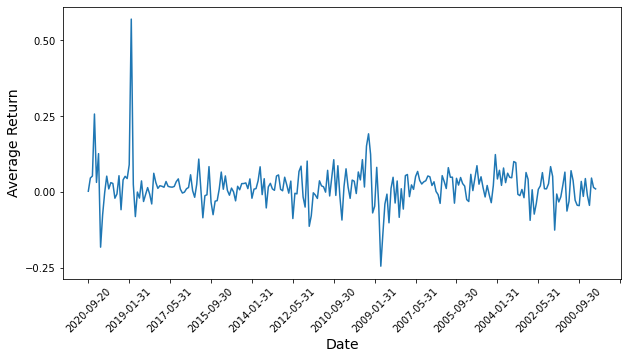

In [10]:
fig, ax = plt.subplots(1,1,figsize=(10,5))
plt.plot(df)
plt.locator_params(nbins=4)

ax.xaxis.set_major_locator(plt.MaxNLocator(18))
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Average Return', fontsize=14);

The time series looks fairly stationary. Let us check by using the ADF test. The ADF tests the null hypothesis that the data is non-stationary. So, if the ADF test returns a p-value less than 0.05 then the null hypothesis is rejected and the time series is stationary.

In [11]:
p_value = adfuller(df)[1]
print("The p-value for the ADF test is %.4f" % p_value)

The p-value for the ADF test is 0.0000


The p-value is less than 0.05 so the time series is stationary. Let us repeat this process for the rest of the time series in the data folder.

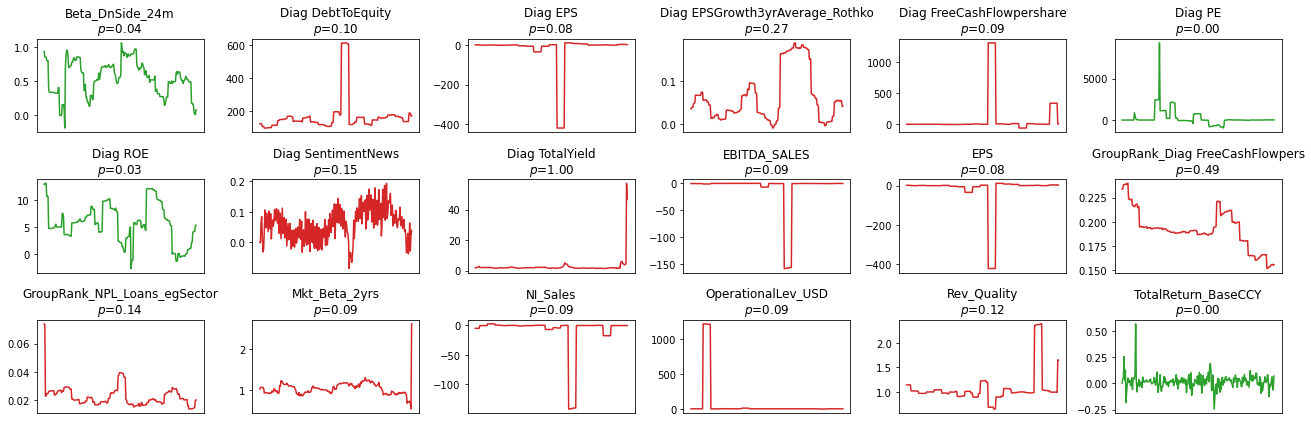

In [12]:
files = os.listdir("Data")

# create a dataframe X that will store the time series 
file = files[0]
path = "Data/" + file
df = pd.read_csv(path)
cols = df.columns[4:-12] # do not include the non-numeric columns, and data from the year 2000
X = pd.DataFrame(columns=cols)

for file in files:
    path = "Data/" + file
    df = pd.read_csv(path)
    df = df[cols]
    
    # calculate the mean in each column
    df = df.mean(axis=0)

    rowname = file[:-4] # remove '.csv' from the end of the file name
    X.loc[rowname] = df

# plot each of the 18 time series in X
fig, ax = plt.subplots(3,6,figsize=(18,6))
for i in range(3):
    for j in range(6):
        row = X.iloc[i*6 + j]
        p_value = adfuller(row)[1]
        
        if p_value < 0.05:
            # if the time series is stationary plot it in green
            sns.lineplot(data=row, ax=ax[i][j], color='tab:green')
        else:
            # if the time series is not stationary plot it in red
            sns.lineplot(data=row, ax=ax[i][j], color='tab:red')
            
        ax[i][j].set_xticks([])
        ax[i][j].set_ylabel("")
        p_value_str = '%.2f' % p_value # convert the p-value to string to two decimal places
        
        title = X.iloc[i*6 + j].name + "\n" + r"$p$=" + p_value_str
        ax[i][j].set_title(title, fontsize=12)

fig.tight_layout()

The above plot shows the 18 time series we have extracted. A red line means that the time series is not sationary (p > 0.05), and a green line means that the time series is stationart (p < 0.05). So, only four of the time series are stationary as they stand. Perhaps the most significant issues in terms of stationarity are the peaks that we see in ```DIAG EPS``` for example. This peak could be caused by a few massively negative values in the data so we can try and deal with this by clipping the data before we calculate the mean.

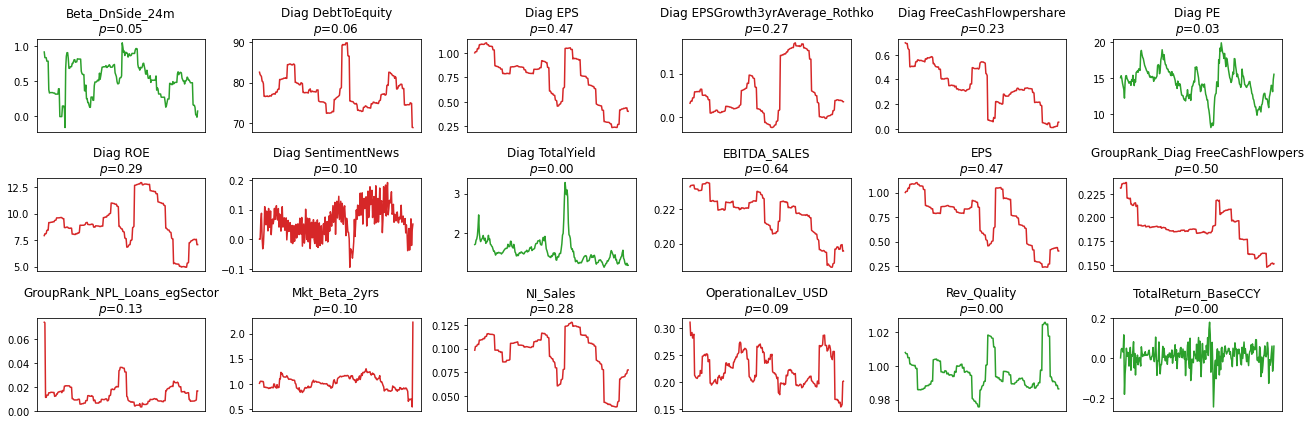

In [13]:
files = os.listdir("Data")

# create a dataframe X that will store the time series 
file = files[0]
path = "Data/" + file
df = pd.read_csv(path)
cols = df.columns[4:-12] # do not include the non-numeric columns, and data from the year 2000
X = pd.DataFrame(columns=cols)

for file in files:
    path = "Data/" + file
    df = pd.read_csv(path)
    df = df[cols]
    
    # bound the columns
    upperlim = df.quantile(0.95, axis='index')
    lowerlim = df.quantile(0.05, axis='index')
    df = df.clip(lower=lowerlim, upper=upperlim, axis=1)
    
    # calculate the mean in each column
    df = df.mean(axis=0)

    rowname = file[:-4] # remove '.csv' from the end of the file name
    X.loc[rowname] = df

# plot each of the 18 time series in X
fig, ax = plt.subplots(3,6,figsize=(18,6))
for i in range(3):
    for j in range(6):
        row = X.iloc[i*6 + j]
        p_value = adfuller(row)[1]
        
        if p_value < 0.05:
            # if the time series is stationary plot it in green
            sns.lineplot(data=row, ax=ax[i][j], color='tab:green')
        else:
            # if the time series is not stationary plot it in red
            sns.lineplot(data=row, ax=ax[i][j], color='tab:red')
            
        ax[i][j].set_xticks([])
        ax[i][j].set_ylabel("")
        p_value_str = '%.2f' % p_value # convert the p-value to string to two decimal places
        
        title = X.iloc[i*6 + j].name + "\n" + r"$p$=" + p_value_str
        ax[i][j].set_title(title, fontsize=12)
fig.tight_layout()

This is a move in the right direction. We have removed some of the peaks in the data, and we now have 5 time series that are stationary. However, now there seems to be some trends appearing in the data. For example, in ```Diag FreeCashFlowpershare``` there looks to be a negative trend. We can try and reduce these trends by differencing the time series. Let $\mathbf{x}_i$ be a time series where 
$$
    \mathbf{x}_i = 
    \begin{bmatrix}
    x_{i,1} & x_{i,2} & \dots & x_{i,n}
    \end{bmatrix}.
$$
To difference $\mathbf{x}_i$, for each value $x_{i,j}$ we take away the previous value in the time series so
$$
    x_{i,j} = x_{i,j} - x_{i,j-1}.
$$
Note that if $j$ is 0 then differencing does not make sense since $x_{i,-1}$ is undefined. We therefore remove $x_{i,0}$ after the data has been differenced. In fact since I found some large peaks in the at the start and end of some of the time series, I have removed the first and last 5 datapoints aswell.

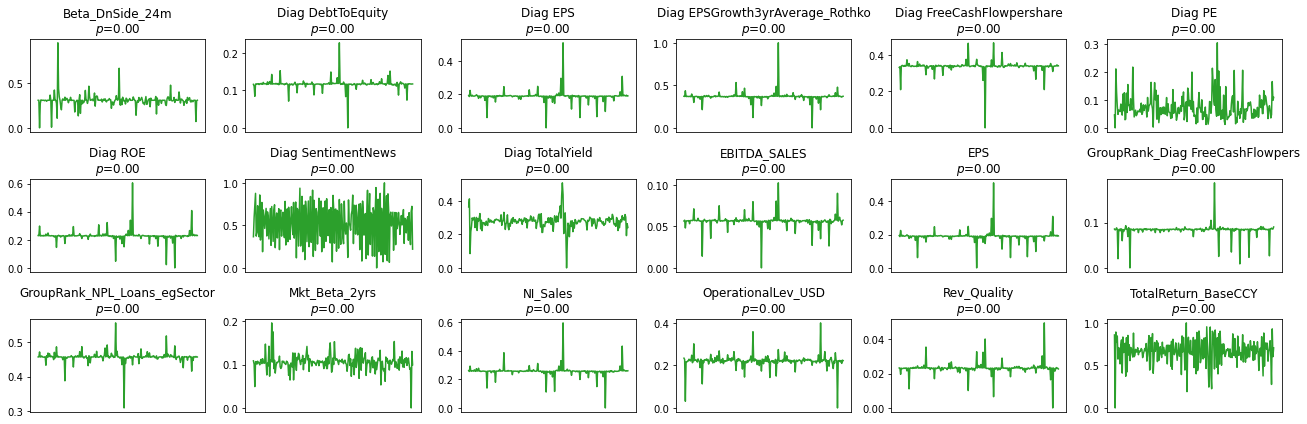

In [14]:
files = os.listdir("Data")

# create a dataframe X that will store the time series 
file = files[0]
path = "Data/" + file
df = pd.read_csv(path)
cols = df.columns[4:-12] # do not include the non-numeric columns, and data from the year 2000
X = pd.DataFrame(columns=cols)

for file in files:
    path = "Data/" + file
    df = pd.read_csv(path)
    df = df[cols]
    
    # bound the data
    upperlim = df.quantile(0.95, axis='index')
    lowerlim = df.quantile(0.05, axis='index')
    df = df.clip(lower=lowerlim, upper=upperlim, axis=1)
    
    # calculate the mean in each column
    df = df.mean(axis=0)
    
    # difference the time series
    df[1:] = df[1:] - df[:-1].values
    
    # scale the time series to be between 0 and 1
    df -= df.min()
    df /= df.max()

    rowname = file[:-4] # remove '.csv' from the end of the file name
    X.loc[rowname] = df

# remove the first column from the time series
X = X[X.columns[5:-5]]

# plot each of the 18 time series in X
fig, ax = plt.subplots(3,6,figsize=(18,6))
for i in range(3):
    for j in range(6):
        row = X.iloc[i*6 + j]
        p_value = adfuller(row)[1]
        
        if p_value < 0.05:
            # if the time series is stationary plot it in green
            sns.lineplot(data=row, ax=ax[i][j], color='tab:green')
        else:
            # if the time series is not stationary plot it in red
            sns.lineplot(data=row, ax=ax[i][j], color='tab:red')
            
        ax[i][j].set_xticks([])
        ax[i][j].set_ylabel("")
        p_value_str = '%.2f' % p_value # convert the p-value to string to two decimal places
        
        title = X.iloc[i*6 + j].name + "\n" + r"$p$=" + p_value_str
        ax[i][j].set_title(title, fontsize=12)

fig.tight_layout()

All of our time series are now stationary. The time series are now stationary so we start looking at the granger causality between the time series. But first we need to quickly discuss autoregressive models.

## Autoregression models

Let us suppose we have some time series $\mathbf{x}_i$. An autoregressive model makes a prediction of the value of $\mathbf{x}_i$ at time $t$ by using the past values $\mathbf{x}_i$. An autoregression model has the following form:

$$
    x_{i,t} = w_{i, 1} x_{i, t-1} + w_{i, 2} x_{i, t-2} + \dots + w_{i, n} x_{i, t-n} + \epsilon_{i, t}
$$

The coefficients $w_{i, 1}, w_{i, 2}, \dots, w_{i, n}$ are learned during to training to reduce the error term $\epsilon_{i, t}$.

## Granger causality

Granger causality comes in a few different varieties. In this notebook, we will discuss parwise granger causality which is a way of finding the "causal" relationships between pairs of time series.

Let us suppose we have two time series $\mathbf{x}_i$ and $\mathbf{x}_j$, and we want to see if $\mathbf{x}_j$ causes $\mathbf{x}_i$. To do this we fit two autoregressive models to $\mathbf{x}_i$. The first model is what we call the ***full model*** which uses the past of $\mathbf{x}_i$ and $\mathbf{x}_j$ to make its predictions. Mathematically, the full model has the following form

$$
x_{i,t} = w_{i, 1} x_{i, t-1} + w_{i, 2} x_{i, t-2} + \dots + w_{i, n} x_{i, t-n} + w_{j, 1} x_{j, t-1} + w_{j, 2} x_{j, t-2} + \dots + w_{j, n} x_{j, t-n} + \epsilon_{i, t}.
$$

The second model which we will call the ***reduced model*** only uses the past of $\mathbf{x}_i$ to make its predictions,

$$
\mathbf{x}_i = \bar{w}_{i, 1} x_{i, t-1} + \bar{w}_{i, 2} x_{i, t-2} + \dots + \bar{w}_{i, n} x_{i, t-n} + \bar{\epsilon}_{i, t}.
$$

We then say the $\mathbf{x}_j$ granger causes $\mathbf{x}_i$ if there is a statistically significiant reduction in the error in the full model as opposed to the reduced model. There are a number of ways that one could go about testing for this statiscially significant reduction in error. Here we will use an F-test. An F-test is another type of hypothesis test where the null hypothesis is that the full model does not provide a significant reduction in the error than the reduced model. So if the F-test gives a p-value less than 0.05 then the full model gives a statistically significant reduction in the  error, and therefore $\mathbf{x}_j$ granger causes $\mathbf{x}_i$.

As an example, let us test to see if ```Diag SentimentNews``` granger causes ```TotalReturn_BaseCCY```.

In [15]:
from statsmodels.tsa.stattools import grangercausalitytests

data = X.T
data = data[['TotalReturn_BaseCCY', 'Diag SentimentNews']]

# test to see if the seconds column in 'data' granger-causes the first column
gc = grangercausalitytests(
    data, 
    maxlag=10, 
    verbose=False
)

# create a dataframe to store the f-statistics and p-values from the granger causality tests
results = pd.DataFrame(index=list(range(1,11)), columns=['f-statistic', 'p-value'])
results.index.name = 'lag' # name the index column lag

# Extract the relevant information from the granger causality test
for i in range(1,11):
    f_stat = gc[i][0]['ssr_ftest'][0]
    p_value = gc[i][0]['ssr_ftest'][1]
    results.loc[i] = [f_stat, p_value]
results

,f-statistic,p-value
lag,,
1,0.70577,0.401751
2,0.28968,0.748788
3,0.45323,0.715276
4,1.296767,0.272343
5,2.152824,0.060543
6,1.975044,0.070626
7,2.954823,0.005694
8,2.8774,0.0047
9,3.162517,0.001366


From the table above, for lags above 8 we have a p-value less than 0.05. So, the null-hypothesis is rejected and thus ```Diag SentimentNews``` granger causes ```TotalReturn_BaseCCY```. Let us now test for granger-causal relationships between the rest of our time series. 

In [16]:
data = X.T

names = list(data.columns)
x = list(range(len(names)))
xx, yy = np.meshgrid(x, x)

mat = pd.DataFrame(index=names, columns=names, dtype='float64')
xx, yy = np.meshgrid(x, x)
for (x, y) in zip(xx.flatten(), yy.flatten()):
    namex = names[x]
    namey = names[y]
    data.loc[:,[namex, namey]]
    gc = grangercausalitytests(
        data.loc[:,[namex, namey]], 
        maxlag=10, 
        verbose=False
    )
    
    smallest_p = np.inf
    for i in range(10):
        p = gc[10][0]['ssr_ftest'][1]
        if p < smallest_p:
            smallest_p = p
        
    mat.loc[namex, namey] = p
mat

,Beta_DnSide_24m,Diag DebtToEquity,Diag EPS,Diag EPSGrowth3yrAverage_Rothko,Diag FreeCashFlowpershare,Diag PE,Diag ROE,Diag SentimentNews,Diag TotalYield,EBITDA_SALES,EPS,GroupRank_Diag FreeCashFlowpers,GroupRank_NPL_Loans_egSector,Mkt_Beta_2yrs,NI_Sales,OperationalLev_USD,Rev_Quality,TotalReturn_BaseCCY
Beta_DnSide_24m,1.000000,0.277312,8.824839e-03,4.148177e-01,0.994694,0.916006,0.023412,0.326795,8.085309e-01,0.000384,8.824839e-03,0.023602,0.323109,0.004916,0.022204,0.052600,0.363054,1.520813e-02
Diag DebtToEquity,0.204957,1.000000,2.686975e-01,9.396820e-01,0.853680,0.637597,0.458121,0.390121,9.461895e-05,0.763278,2.686975e-01,0.842935,0.458077,0.990468,0.683826,0.987995,0.938917,4.138368e-02
Diag EPS,0.992496,0.368649,1.000000e+00,9.979086e-01,0.313938,0.993085,0.976754,0.002527,2.662458e-06,0.999899,1.000000e+00,0.618115,0.227536,0.302643,0.362647,0.945943,0.603538,3.106935e-01
Diag EPSGrowth3yrAverage_Rothko,0.968088,0.798587,9.993682e-01,1.000000e+00,0.926043,0.667124,0.999996,0.120281,2.338386e-09,0.974174,9.993682e-01,0.037918,0.892175,0.786979,0.995862,0.989367,0.974921,1.657381e-03
Diag FreeCashFlowpershare,0.010079,0.992164,9.515159e-01,9.980470e-01,1.000000,0.785952,0.851913,0.747311,6.523875e-01,0.856142,9.515159e-01,0.893048,0.948209,0.665292,0.970472,0.910002,0.753735,3.952365e-01
Diag PE,0.518601,0.006779,6.199963e-03,1.606372e-01,0.743271,1.000000,0.023849,0.000101,2.362954e-02,0.072026,6.199963e-03,0.217101,0.734818,0.325812,0.010630,0.663902,0.556008,9.934064e-26
Diag ROE,0.996873,0.125306,9.567776e-01,9.999518e-01,0.397566,0.972960,1.000000,0.024357,7.520332e-06,0.997573,9.567776e-01,0.237296,0.278180,0.580302,0.593881,0.996411,0.806148,1.253017e-01
Diag SentimentNews,0.980094,0.000127,1.039121e-04,4.767548e-03,0.000092,0.044319,0.000172,1.000000,5.305556e-04,0.005981,1.039121e-04,0.061838,0.066055,0.756488,0.000077,0.168753,0.081845,1.356663e-01
Diag TotalYield,0.965133,0.000480,4.605393e-02,4.547413e-03,0.023941,0.006524,0.129707,0.116237,1.000000e+00,0.466584,4.605393e-02,0.719308,0.028592,0.449861,0.064511,0.733003,0.143826,5.290129e-61
EBITDA_SALES,0.671412,0.875234,9.818783e-01,9.969155e-01,0.411056,0.993791,0.999861,0.057624,2.423072e-01,1.000000,9.818783e-01,0.186128,0.262456,0.212089,0.999993,0.997905,0.687738,6.324997e-01


The above table shows the p-values from the granger causality tests for every pair of timeseries. It is fairly difficult to see the pairings which have a p-value less than 0.05 so let us plot a heatmap to make this a little easier.

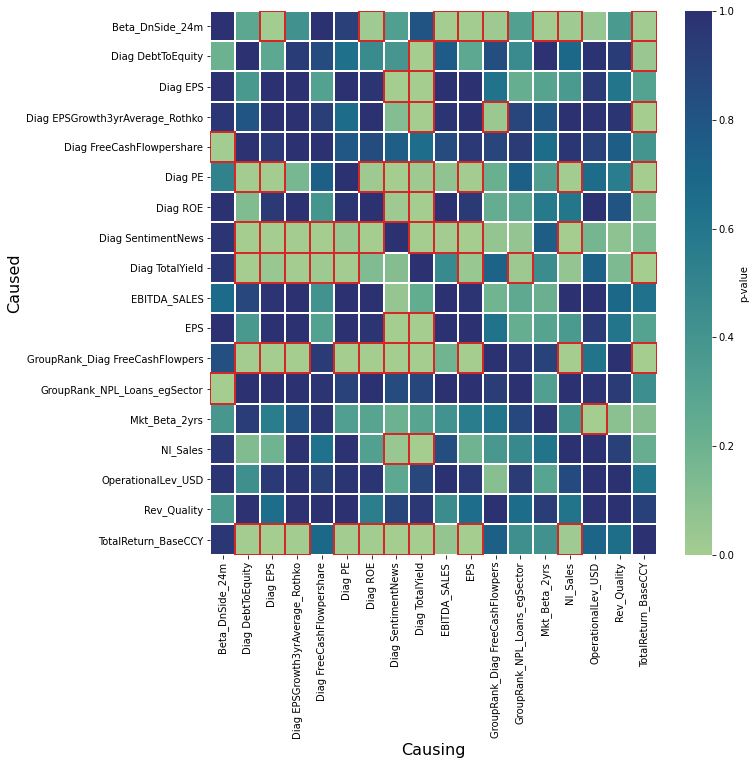

In [17]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(1,1,figsize=(10,10))
sns.heatmap(mat, ax=ax, linewidth=1, cmap='crest',
           cbar_kws={'label': 'p-value'})

# highlight the cell in red if the p-value is less than 0.05
for (x, y) in zip(xx.flatten(), yy.flatten()):
    if mat.iloc[x, y] < 0.05:
        ax.add_patch(Rectangle((y, x), 1, 1, fill=False, edgecolor='tab:red', lw=2))
        
ax.set_xlabel("Causing", fontsize=16)
ax.set_ylabel("Caused", fontsize=16);

The above heatmap shows the p-values from the granger causality tests we performed for each pair of time series. Any parings that have a p-value less than 0.05 have been highligted red. For example this means ```NI_Sales``` is caused by ```Diag SentimentNews```, and ```Diag TotalYield```.

It is important to mention that granger causality is by no means a reflection of true causality. The [wikipedia page](https://en.wikipedia.org/wiki/Granger_causality) on granger causality has the following quote:

<blockquote> Using the term "causality" alone is a misnomer, as Granger-causality is better described as "precedence" or, as Granger himself later claimed in 1977, "temporally related" Rather than testing whether Y causes X, the Granger causality tests whether Y forecasts X. </blockquote>

Granger causality and autoregressive models are a classic approach to forecasting and analysing time series. However, as we will see more modern machine learning approached tend to find very different temporal dependencies in the data.